In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from nltk.corpus import stopwords
import pickle
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import random
import math
from textblob import TextBlob
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk, string
from collections import Counter
from nltk.stem import WordNetLemmatizer 
import Levenshtein
import fasttext
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, concatenate, MaxPool1D, Dropout, GlobalMaxPool1D, BatchNormalization, Input, Flatten, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1, l1_l2
%matplotlib inline

In [2]:
import tensorflow as tf
tf.config.experimental.allow_growth = True

In [3]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [4]:
# Setting seed
global_seed = 42
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [5]:
# loading the dataframes in which features have already been extracted
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")

In [6]:
# getting lists of sentence1 and sentence 2 for train and validation datsets
train_sentence1 = train_df['sentence1_preprocessed'].tolist()
train_sentence2 = train_df['sentence2_preprocessed'].tolist()
val_sentence1 = val_df['sentence1_preprocessed'].tolist()
val_sentence2 = val_df['sentence2_preprocessed'].tolist()

# MLP on avg fasttext embeddings and extracted features

In [7]:
x_train_s1_avg_fasttext = np.load('x_train_s1_avg_fasttext.npy', mmap_mode='r')
x_train_s2_avg_fasttext = np.load('x_train_s2_avg_fasttext.npy', mmap_mode='r')
x_val_s1_avg_fasttext = np.load('x_val_s1_avg_fasttext.npy', mmap_mode='r')
x_val_s2_avg_fasttext = np.load('x_val_s2_avg_fasttext.npy', mmap_mode='r')
x_test_s1_avg_fasttext = np.load('x_test_s1_avg_fasttext.npy', mmap_mode='r')
x_test_s2_avg_fasttext = np.load('x_test_s2_avg_fasttext.npy', mmap_mode='r')

In [8]:
to_keep = ['log_bleu_score', 'sum_polarity', 'diff_subjectivity',
       'cosine_similarity', 'tfidf_cosine_sim', 'diff_num_words', 's1_CC',
       's1_IN','s1_PRP', 's1_PRP$', 's1_RB', 's1_RBR', 's1_RBS', 's1_UH', 's1_VB', 's2_CC', 's2_IN', 's2_PRP',
       's2_PRP$', 's2_RB', 's2_RBR', 's2_RBS', 's2_UH', 'ratio_noun', 'ratio_verb', 
       'diff_adjective', 'levenshtein_dist', 'tfidf_w2v_cosine',
       'tfidf_cosine_sim_ngram']

In [9]:
X_train_1 = train_df[to_keep]
y_train = train_df['gold_label']
X_val_1 = val_df[to_keep]
y_val = val_df['gold_label']

In [10]:
y_train.replace(to_replace = ['neutral', 'contradiction', 'entailment'] , value = [0, 1, 2], inplace = True)
y_val.replace(to_replace = ['neutral', 'contradiction', 'entailment'] , value = [0, 1, 2], inplace = True)

In [11]:
y_train_enc = to_categorical(y_train)
y_val_enc = to_categorical(y_val)

In [12]:
input1 = Input(shape=(29,)) #for extracted features
input2 = Input(shape=(300,)) #for sentence1 embeddings
input3 = Input(shape=(300,)) #for sentence2 embeddings
merged = concatenate([input1, input2, input3]) #merging all inputs
norm1 = BatchNormalization()(merged)
norm1 = tf.expand_dims(norm1, axis=-1)
conv1 = Conv1D(filters = 128, kernel_size = 3, strides=1, padding="valid")(norm1)
conv2 = Conv1D(filters = 64, kernel_size = 3, strides=1, padding="valid")(conv1)
conv3 = Conv1D(filters = 32, kernel_size = 3, strides=1, padding="valid")(conv2)
flat = Flatten()(conv3)
dense1 = Dense(units = 1024, activation = 'relu')(flat)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(units = 512, activation = 'relu')(drop1)
drop2 = Dropout(0.3)(dense2)
dense3 = Dense(units = 256, activation = 'relu')(drop2)
drop3 = Dropout(0.3)(dense3)
norm2 = BatchNormalization()(drop3)
dense4 = Dense(units = 128, activation = 'relu')(norm2)
drop4 = Dropout(0.3)(dense4)
dense5 = Dense(units = 64, activation = 'relu')(dense4)
dense6 = Dense(units = 32, activation = 'relu')(dense5)
dense7 = Dense(units = 16, activation = 'relu')(dense6)

output = Dense(units = 3, activation = 'softmax')(dense7)
model1 = Model(inputs = [input1, input2, input3], outputs = output)


In [13]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import tensorflow as tf
# learning rate schedule
def step_decay(epoch):

    import math
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 8.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 10)
fname = 'model1.h5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate,es]

model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
model1.fit([X_train_1, x_train_s1_avg_fasttext, x_train_s2_avg_fasttext], y_train_enc, epochs = 50, batch_size = 64, 
           validation_data = ([X_val_1, x_val_s1_avg_fasttext, x_val_s2_avg_fasttext], y_val_enc), callbacks = callbacks)

Epoch 1/50
8584/8584 [==============================] - 138s 15ms/step - loss: 0.8259 - accuracy: 0.6294 - val_loss: 0.7223 - val_accuracy: 0.6886
Epoch 2/50
8584/8584 [==============================] - 133s 15ms/step - loss: 0.7248 - accuracy: 0.6882 - val_loss: 0.6653 - val_accuracy: 0.7200
Epoch 3/50
8584/8584 [==============================] - 134s 16ms/step - loss: 0.6826 - accuracy: 0.7109 - val_loss: 0.6237 - val_accuracy: 0.7386
Epoch 4/50
8584/8584 [==============================] - 137s 16ms/step - loss: 0.6552 - accuracy: 0.7242 - val_loss: 0.6206 - val_accuracy: 0.7393
Epoch 5/50
8584/8584 [==============================] - 136s 16ms/step - loss: 0.6347 - accuracy: 0.7351 - val_loss: 0.6062 - val_accuracy: 0.7470
Epoch 6/50
8584/8584 [==============================] - 137s 16ms/step - loss: 0.6181 - accuracy: 0.7433 - val_loss: 0.5879 - val_accuracy: 0.7530
Epoch 7/50
8584/8584 [==============================] - 138s 16ms/step - loss: 0.6045 - accuracy: 0.7499 - val_loss: 0

# Sequence modeling

**We will be using following general architecture for modelling:** 

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/6q4df1V.png")

# train sentence1 tokenize > token to ids > padding

In [12]:
num_words = None
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
# Tokenize our training data
tokenizer1 = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer1.fit_on_texts(train_sentence1)

# Get our training data word index
word_index1 = tokenizer1.word_index

# Encode training data sentences into sequences
train_sequences_1 = tokenizer1.texts_to_sequences(train_sentence1)

# Get max training sequence length
maxlen1 = max([len(x) for x in train_sequences_1])

# Pad the training sequences
train_padded_1 = pad_sequences(train_sequences_1, padding=pad_type, truncating=trunc_type, maxlen=maxlen1)

# validation sentence1 > tokenize > token to ids > pad

In [13]:
# Encode training data sentences into sequences
val_sequences_1 = tokenizer1.texts_to_sequences(val_sentence1)

# Pad the training sequences
val_padded_1 = pad_sequences(val_sequences_1, padding=pad_type, truncating=trunc_type, maxlen=maxlen1)

# train sentence2 tokenize > token to ids > padding

In [14]:
num_words = None
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
# Tokenize our training data
tokenizer2 = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer2.fit_on_texts(train_sentence2)

# Get our training data word index
word_index2 = tokenizer2.word_index

# Encode training data sentences into sequences
train_sequences_2 = tokenizer2.texts_to_sequences(train_sentence2)

# Get max training sequence length
maxlen2 = max([len(x) for x in train_sequences_2])

# Pad the training sequences
train_padded_2 = pad_sequences(train_sequences_2, padding=pad_type, truncating=trunc_type, maxlen=maxlen2)

# validation sentence1 > tokenize > token to ids > pad

In [15]:
# Encode training data sentences into sequences
val_sequences_2 = tokenizer2.texts_to_sequences(val_sentence2)

# Pad the training sequences
val_padded_2 = pad_sequences(val_sequences_2, padding=pad_type, truncating=trunc_type, maxlen=maxlen2)

In [16]:
vocab_size_1 = len(word_index1) +1
vocab_size_2 = len(word_index2)+1

In [17]:
print(vocab_size_1)
print(vocab_size_2)

17997
30076


# GloVe embeddings

# Sentence1 tokens glove embeddings

In [18]:
#getting glove embeddings for tokens
embeddings_index_1 = dict()
f = open('glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_1[word] = coefs
f.close()

embedding_matrix_glove_1 = np.zeros((vocab_size_1, 300))
for word, i in word_index1.items():
    embedding_vector = embeddings_index_1.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove_1[i] = embedding_vector

# Sentence2 tokens glove embeddings

In [19]:
embedding_matrix_glove_2 = np.zeros((vocab_size_2, 300))
for word, i in word_index2.items():
    embedding_vector = embeddings_index_1.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove_2[i] = embedding_vector

In [20]:
print(embedding_matrix_glove_1.shape)
print(embedding_matrix_glove_2.shape)

(17997, 300)
(30076, 300)


# Fasttext embeddings

In [25]:
#loading oretrained fasttext model
#https://fasttext.cc/docs/en/crawl-vectors.html
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

# Sentence1 tokens fasttext embeddings

In [26]:
embedding_matrix_fasttext_1 = np.zeros((vocab_size_1, 300))
for word, i in word_index1.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext_1[i] = embedding_vector

# Sentence2 tokens fasttext embeddings

In [27]:
embedding_matrix_fasttext_2 = np.zeros((vocab_size_2, 300))
for word, i in word_index2.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext_2[i] = embedding_vector

# Encoding target variable

In [28]:
y_train = train_df['gold_label']
y_val = val_df['gold_label']

In [ ]:
#converting target categories to numbers: neutral:0, contradiction:1, entailment:2
y_train.replace(to_replace = ['neutral', 'contradiction', 'entailment'] , value = [0, 1, 2], inplace = True)
y_val.replace(to_replace = ['neutral', 'contradiction', 'entailment'] , value = [0, 1, 2], inplace = True)

In [31]:
#one hot encoding target
y_train_enc = to_categorical(y_train)
y_val_enc = to_categorical(y_val)

# LSTM with glove embeddings<br>
## we will be taking max over each time step of LSTM

In [47]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_glove_1], trainable = False)(input1)
lstm_s1 = LSTM(128, return_sequences = True)(emb1)
#lstm1 = LSTM(128, return_sequences = True)(lstm_s1)
rs1 = tf.keras.layers.Reshape(target_shape=(maxlen1,128,1))(lstm_s1)
avg1 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPool1D())(rs1)
rs2 = tf.keras.layers.Reshape(target_shape=(maxlen1,))(avg1)
s1_dense = Dense(units = 300, activation = 'relu' )(rs2)


#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_glove_2], trainable = False)(input2)
lstm_s2 = LSTM(128, return_sequences = True)(emb2)
#lstm2 = LSTM(128, return_sequences = True)(lstm_s2)
rs3 = tf.keras.layers.Reshape(target_shape=(maxlen2,128,1))(lstm_s2)
avg2 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(rs3)
rs4 = tf.keras.layers.Reshape(target_shape=(maxlen2,))(avg2)
s2_dense = Dense(units = 300, activation = 'relu' )(rs4)


#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
prod = tf.math.multiply(s1_dense, s2_dense)
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

#concatenating all merged representations
concatenated =  concatenate([merged_representations, prod, abs_diff])

#MLP
dense1 = Dense(units = 100, activation = 'relu')(concatenated)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(units = 50, activation = 'relu')(drop1)
drop2 = Dropout(0.3)(dense2)
dense3 = Dense(units = 25, activation = 'relu')(drop2)
drop3 = Dropout(0.3)(dense3)
output = Dense(units = 3, activation = 'softmax')(drop3)
model1 = Model(inputs = [input1, input2], outputs = output)



In [48]:
model1.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 78, 300)      5399100     input_21[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 57, 300)      9022800     input_22[0][0]                   
____________________________________________________________________________________________

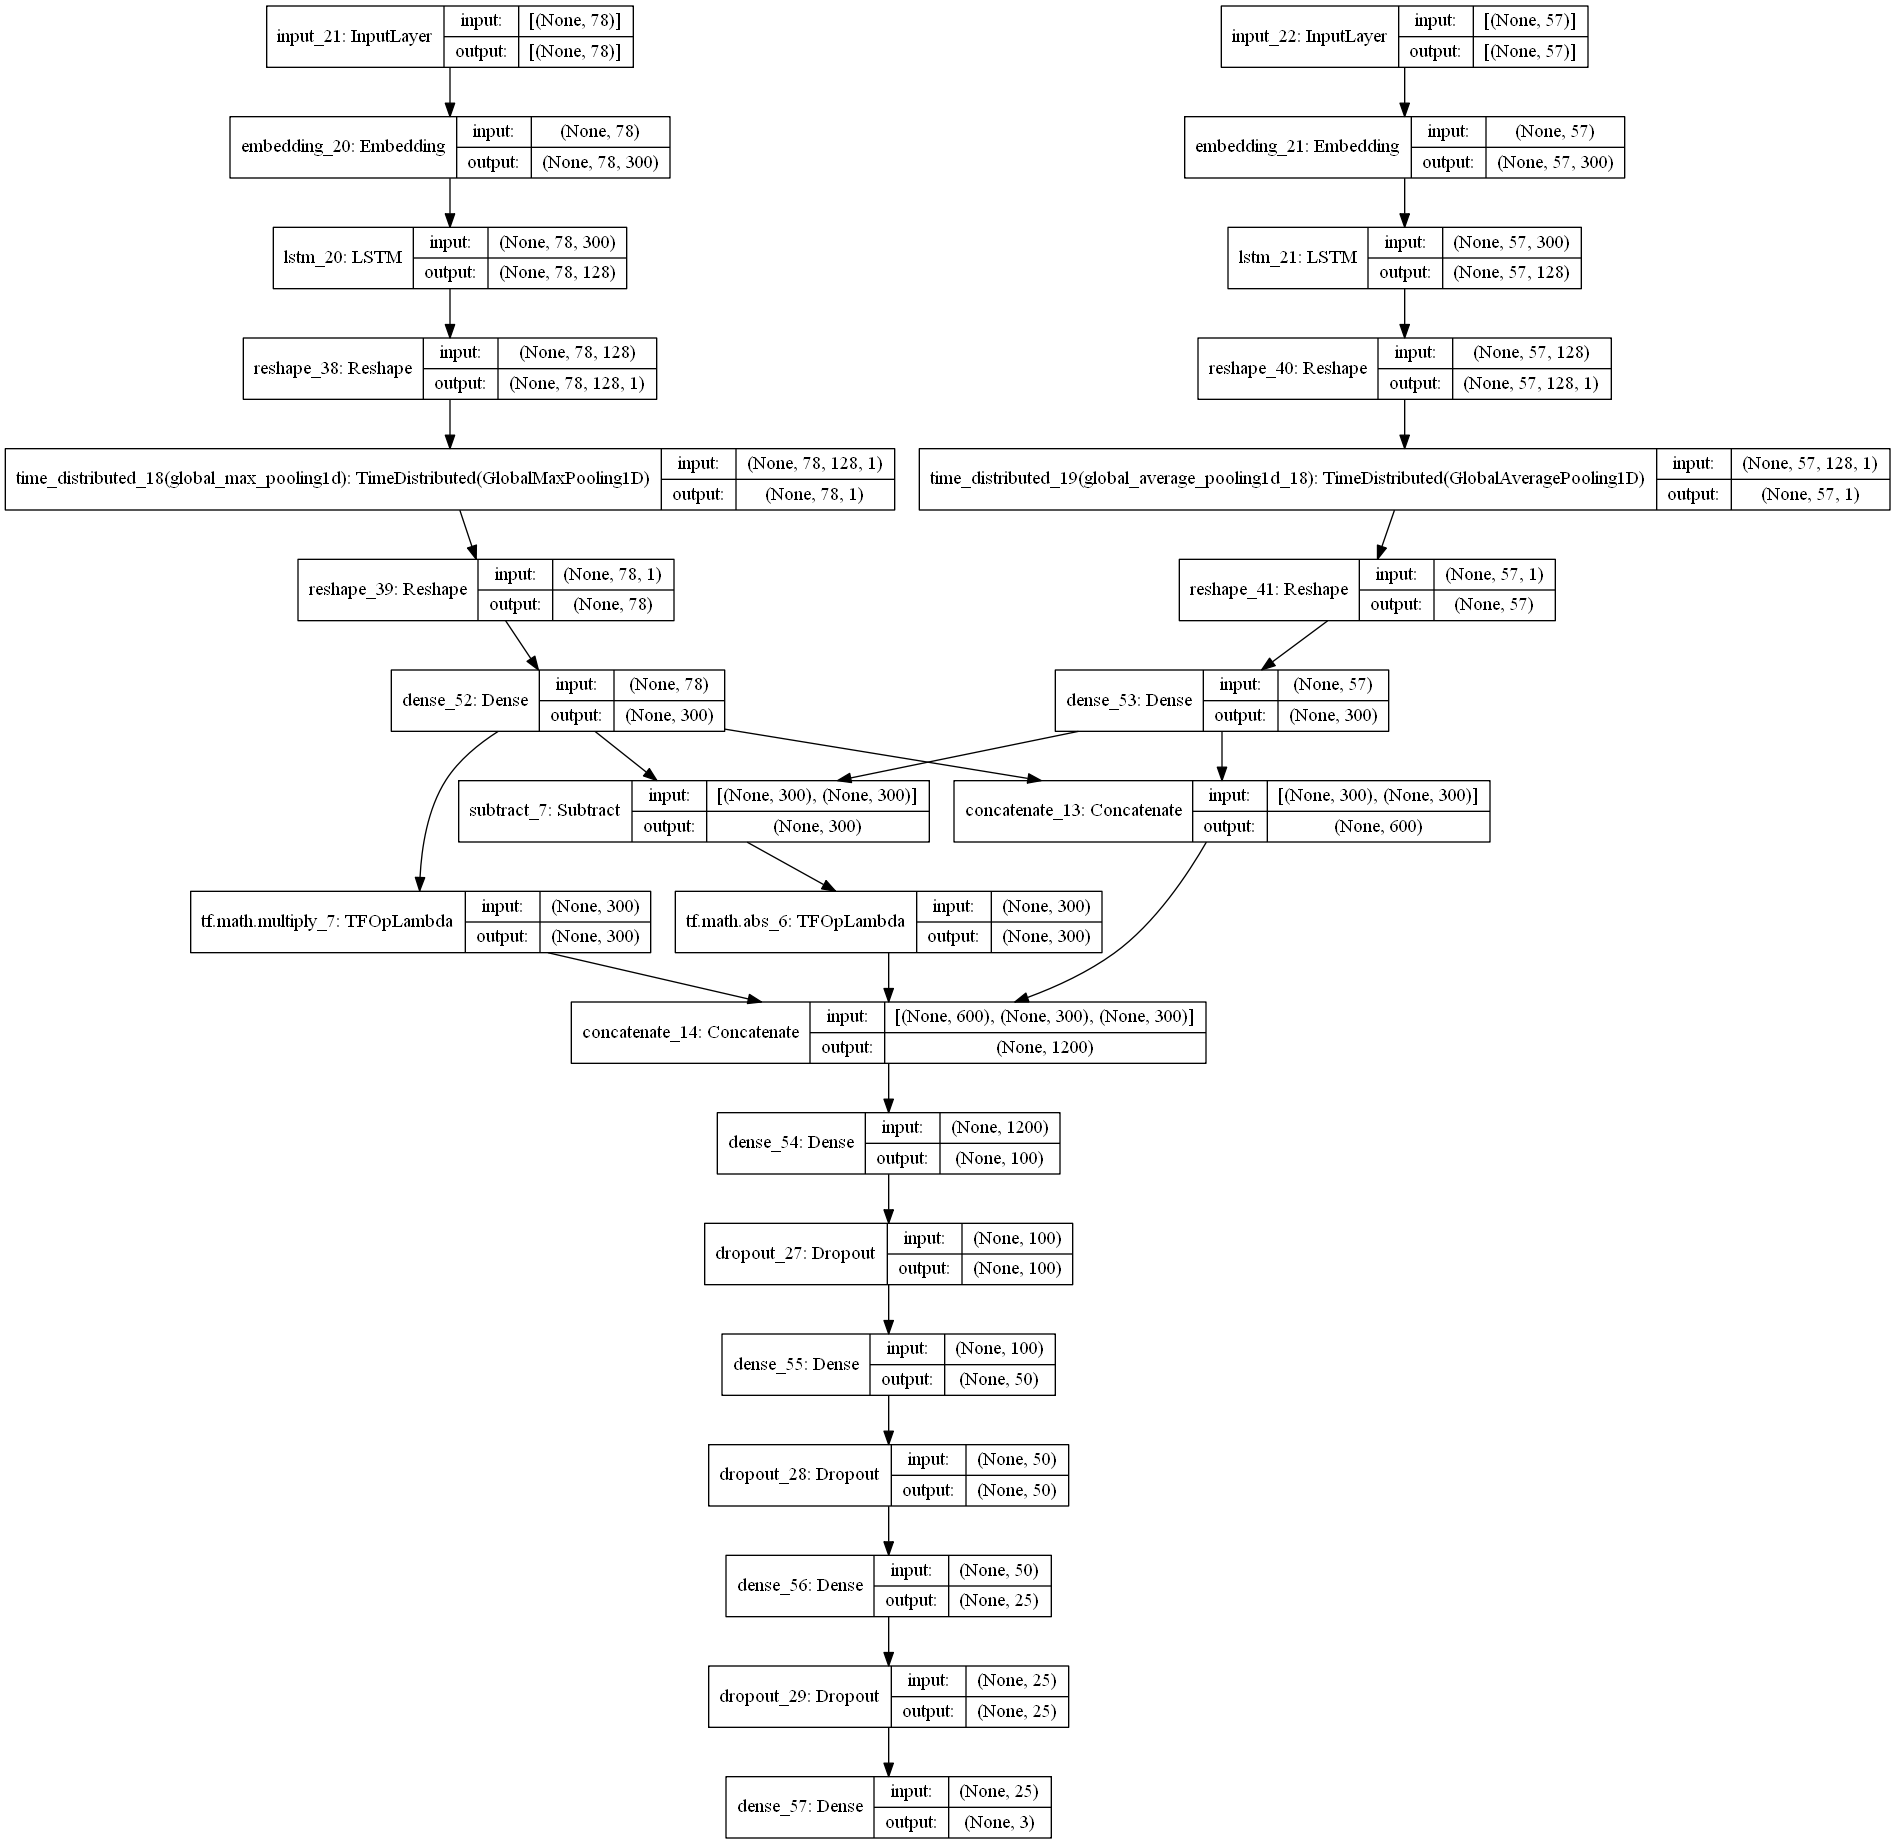

In [49]:
plot_model(model1, to_file='model1.png', show_shapes=True)

In [50]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import tensorflow as tf
# learning rate schedule
def step_decay(epoch):

    import math
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 5)
fname = 'best_model1.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate, es, checkpoint]

In [51]:
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
model1.fit([train_padded_1, train_padded_2], y_train_enc, epochs = 50, batch_size = 1024, 
           validation_data = ([val_padded_1, val_padded_2], y_val_enc), callbacks = callbacks)

Epoch 1/50
537/537 [==============================] - 39s 65ms/step - loss: 0.9134 - accuracy: 0.5709 - val_loss: 0.8058 - val_accuracy: 0.6463
Epoch 2/50
537/537 [==============================] - 35s 65ms/step - loss: 0.8029 - accuracy: 0.6473 - val_loss: 0.7561 - val_accuracy: 0.6712
Epoch 3/50
537/537 [==============================] - 35s 66ms/step - loss: 0.7634 - accuracy: 0.6719 - val_loss: 0.7162 - val_accuracy: 0.6897
Epoch 4/50
537/537 [==============================] - 36s 66ms/step - loss: 0.7351 - accuracy: 0.6884 - val_loss: 0.7070 - val_accuracy: 0.6974
Epoch 5/50
537/537 [==============================] - 36s 67ms/step - loss: 0.7105 - accuracy: 0.7022 - val_loss: 0.6901 - val_accuracy: 0.7050
Epoch 6/50
537/537 [==============================] - 36s 67ms/step - loss: 0.6918 - accuracy: 0.7124 - val_loss: 0.6741 - val_accuracy: 0.7141
Epoch 7/50
537/537 [==============================] - 36s 67ms/step - loss: 0.6735 - accuracy: 0.7219 - val_loss: 0.6777 - val_accuracy:

# LSTM model with fasttext embeddings<br>
## we will be taking max over each time step of LSTM

In [73]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_fasttext_1], trainable = False)(input1)
lstm_s1 = LSTM(128, return_sequences = True)(emb1)
print(lstm_s1.shape)
#lstm1 = LSTM(128, return_sequences = True)(lstm_s1)
rs1 = tf.keras.layers.Reshape(target_shape=(maxlen1,128,1))(lstm_s1)
avg1 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPool1D())(rs1)
rs2 = tf.keras.layers.Reshape(target_shape=(maxlen1,))(avg1)
s1_dense = Dense(units = 100, activation = 'relu' )(rs2)


#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_fasttext_2], trainable = False)(input2)
lstm_s2 = LSTM(128, return_sequences = True)(emb2)
#lstm2 = LSTM(128, return_sequences = True)(lstm_s2)
rs3 = tf.keras.layers.Reshape(target_shape=(maxlen2,128,1))(lstm_s2)
avg2 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(rs3)
rs4 = tf.keras.layers.Reshape(target_shape=(maxlen2,))(avg2)
s2_dense = Dense(units = 100, activation = 'relu' )(rs4)


#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
prod = tf.math.multiply(s1_dense, s2_dense)
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

#concatenating all merged representations
concatenated =  concatenate([merged_representations, prod, abs_diff])

#MLP
dense1 = Dense(units = 100, activation = 'relu')(concatenated)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(units = 25, activation = 'relu')(drop1)
output = Dense(units = 3, activation = 'softmax')(dense2)
model2 = Model(inputs = [input1, input2], outputs = output)



(None, 78, 128)


In [68]:
model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 78, 300)      5399100     input_29[0][0]                   
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 57, 300)      9022800     input_30[0][0]                   
___________________________________________________________________________________________

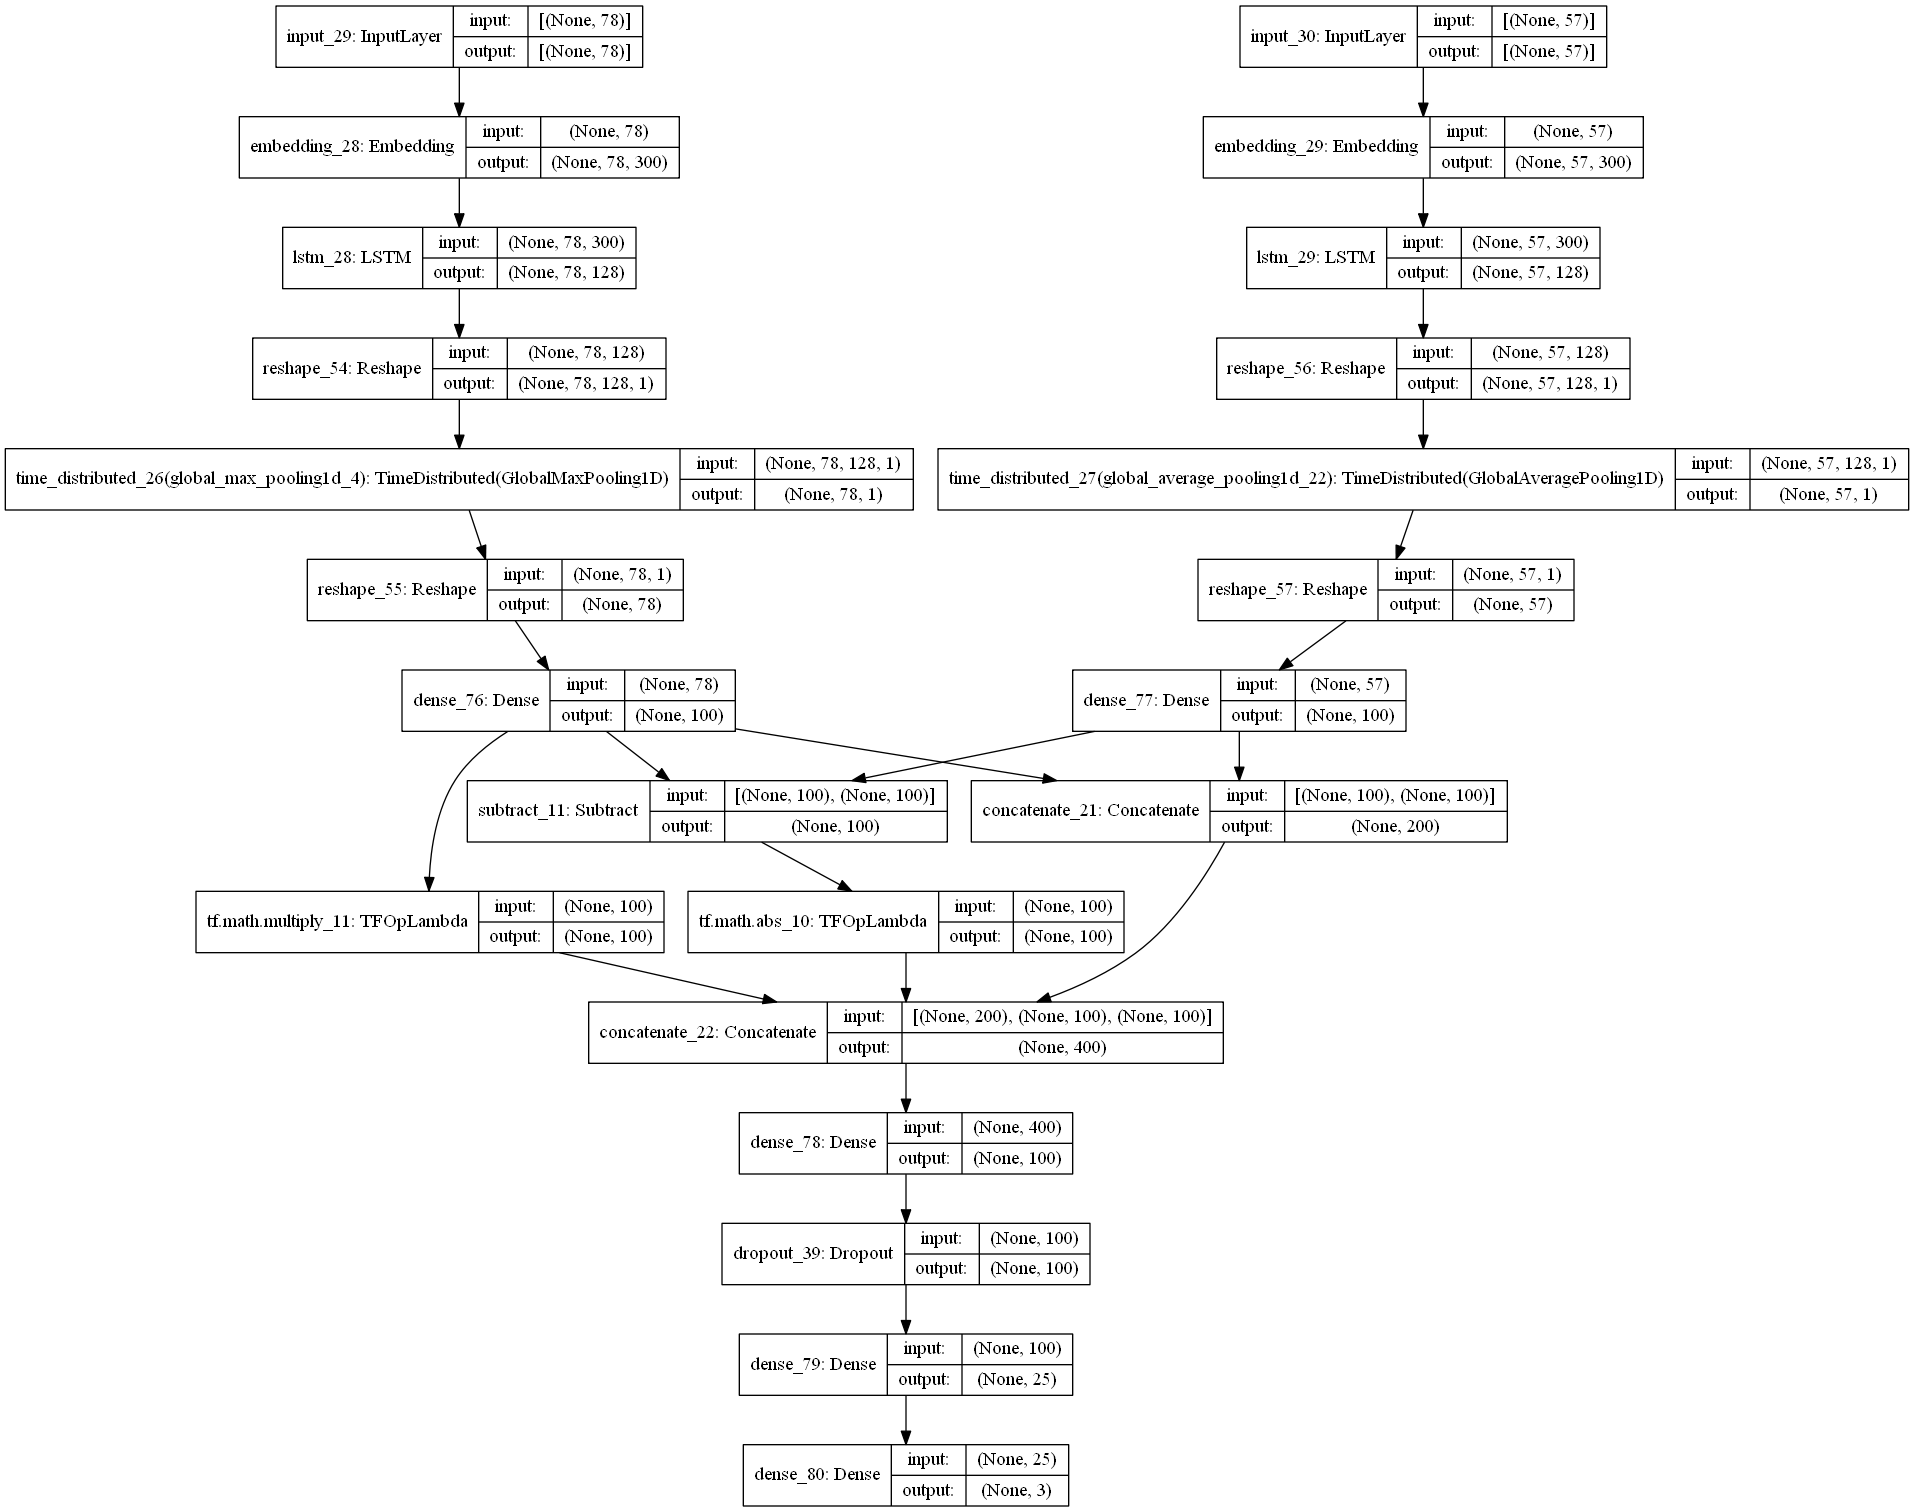

In [69]:
plot_model(model2, to_file='model2.png', show_shapes=True)

In [70]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import tensorflow as tf
# learning rate schedule
def step_decay(epoch):

    import math
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 5)
fname = 'best_model2.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate, checkpoint]

In [71]:
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
model2.fit([train_padded_1, train_padded_2], y_train_enc, epochs = 50, batch_size = 1024, 
           validation_data = ([val_padded_1, val_padded_2], y_val_enc), callbacks = callbacks)

Epoch 1/50
537/537 [==============================] - 39s 65ms/step - loss: 0.9331 - accuracy: 0.5515 - val_loss: 0.8487 - val_accuracy: 0.6084
Epoch 2/50
537/537 [==============================] - 35s 65ms/step - loss: 0.8365 - accuracy: 0.6173 - val_loss: 0.8064 - val_accuracy: 0.6341
Epoch 3/50
537/537 [==============================] - 35s 66ms/step - loss: 0.8049 - accuracy: 0.6353 - val_loss: 0.7946 - val_accuracy: 0.6428
Epoch 4/50
537/537 [==============================] - 35s 66ms/step - loss: 0.7847 - accuracy: 0.6486 - val_loss: 0.7751 - val_accuracy: 0.6569
Epoch 5/50
537/537 [==============================] - 35s 66ms/step - loss: 0.7614 - accuracy: 0.6643 - val_loss: 0.7468 - val_accuracy: 0.6719
Epoch 6/50
537/537 [==============================] - 36s 66ms/step - loss: 0.7399 - accuracy: 0.6770 - val_loss: 0.7252 - val_accuracy: 0.6874
Epoch 7/50
537/537 [==============================] - 36s 67ms/step - loss: 0.7208 - accuracy: 0.6885 - val_loss: 0.7143 - val_accuracy:

# Bidirectional LSTM with fasttext embedding

In [27]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_fasttext_1], trainable = False)(input1)
lstm_s1 = Bidirectional(LSTM(200, return_sequences = True) , merge_mode = 'concat')(emb1)
lstm1 = Bidirectional(LSTM(100, return_sequences = True))(lstm_s1)
rs1 = tf.keras.layers.Reshape(target_shape=(maxlen1,200,1))(lstm1)
avg1 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPool1D())(rs1)
rs2 = tf.keras.layers.Reshape(target_shape=(maxlen1,))(avg1)
s1_dense = Dense(units = 100, activation = 'relu' )(rs2)


#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_fasttext_2], trainable = False)(input2)
lstm_s2 = Bidirectional(LSTM(200, return_sequences = True))(emb2)
lstm2 = Bidirectional(LSTM(100, return_sequences = True))(lstm_s2)
rs3 = tf.keras.layers.Reshape(target_shape=(maxlen2,200,1))(lstm2)
avg2 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(rs3)
rs4 = tf.keras.layers.Reshape(target_shape=(maxlen2,))(avg2)
s2_dense = Dense(units = 100, activation = 'relu' )(rs4)


#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
prod = tf.math.multiply(s1_dense, s2_dense)
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

#concatenating all merged representations
concatenated =  concatenate([merged_representations, prod, abs_diff])

#MLP
dense1 = Dense(units = 100, activation = 'relu')(concatenated)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(units = 50, activation = 'relu')(drop1)
drop2 = Dropout(0.2)(dense2)
dense3 = Dense(units = 10, activation = 'relu')(drop2)
output = Dense(units = 3, activation = 'softmax')(dense3)
model3 = Model(inputs = [input1, input2], outputs = output)



In [28]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 78, 300)      5399100     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 57, 300)      9022800     input_8[0][0]                    
____________________________________________________________________________________________

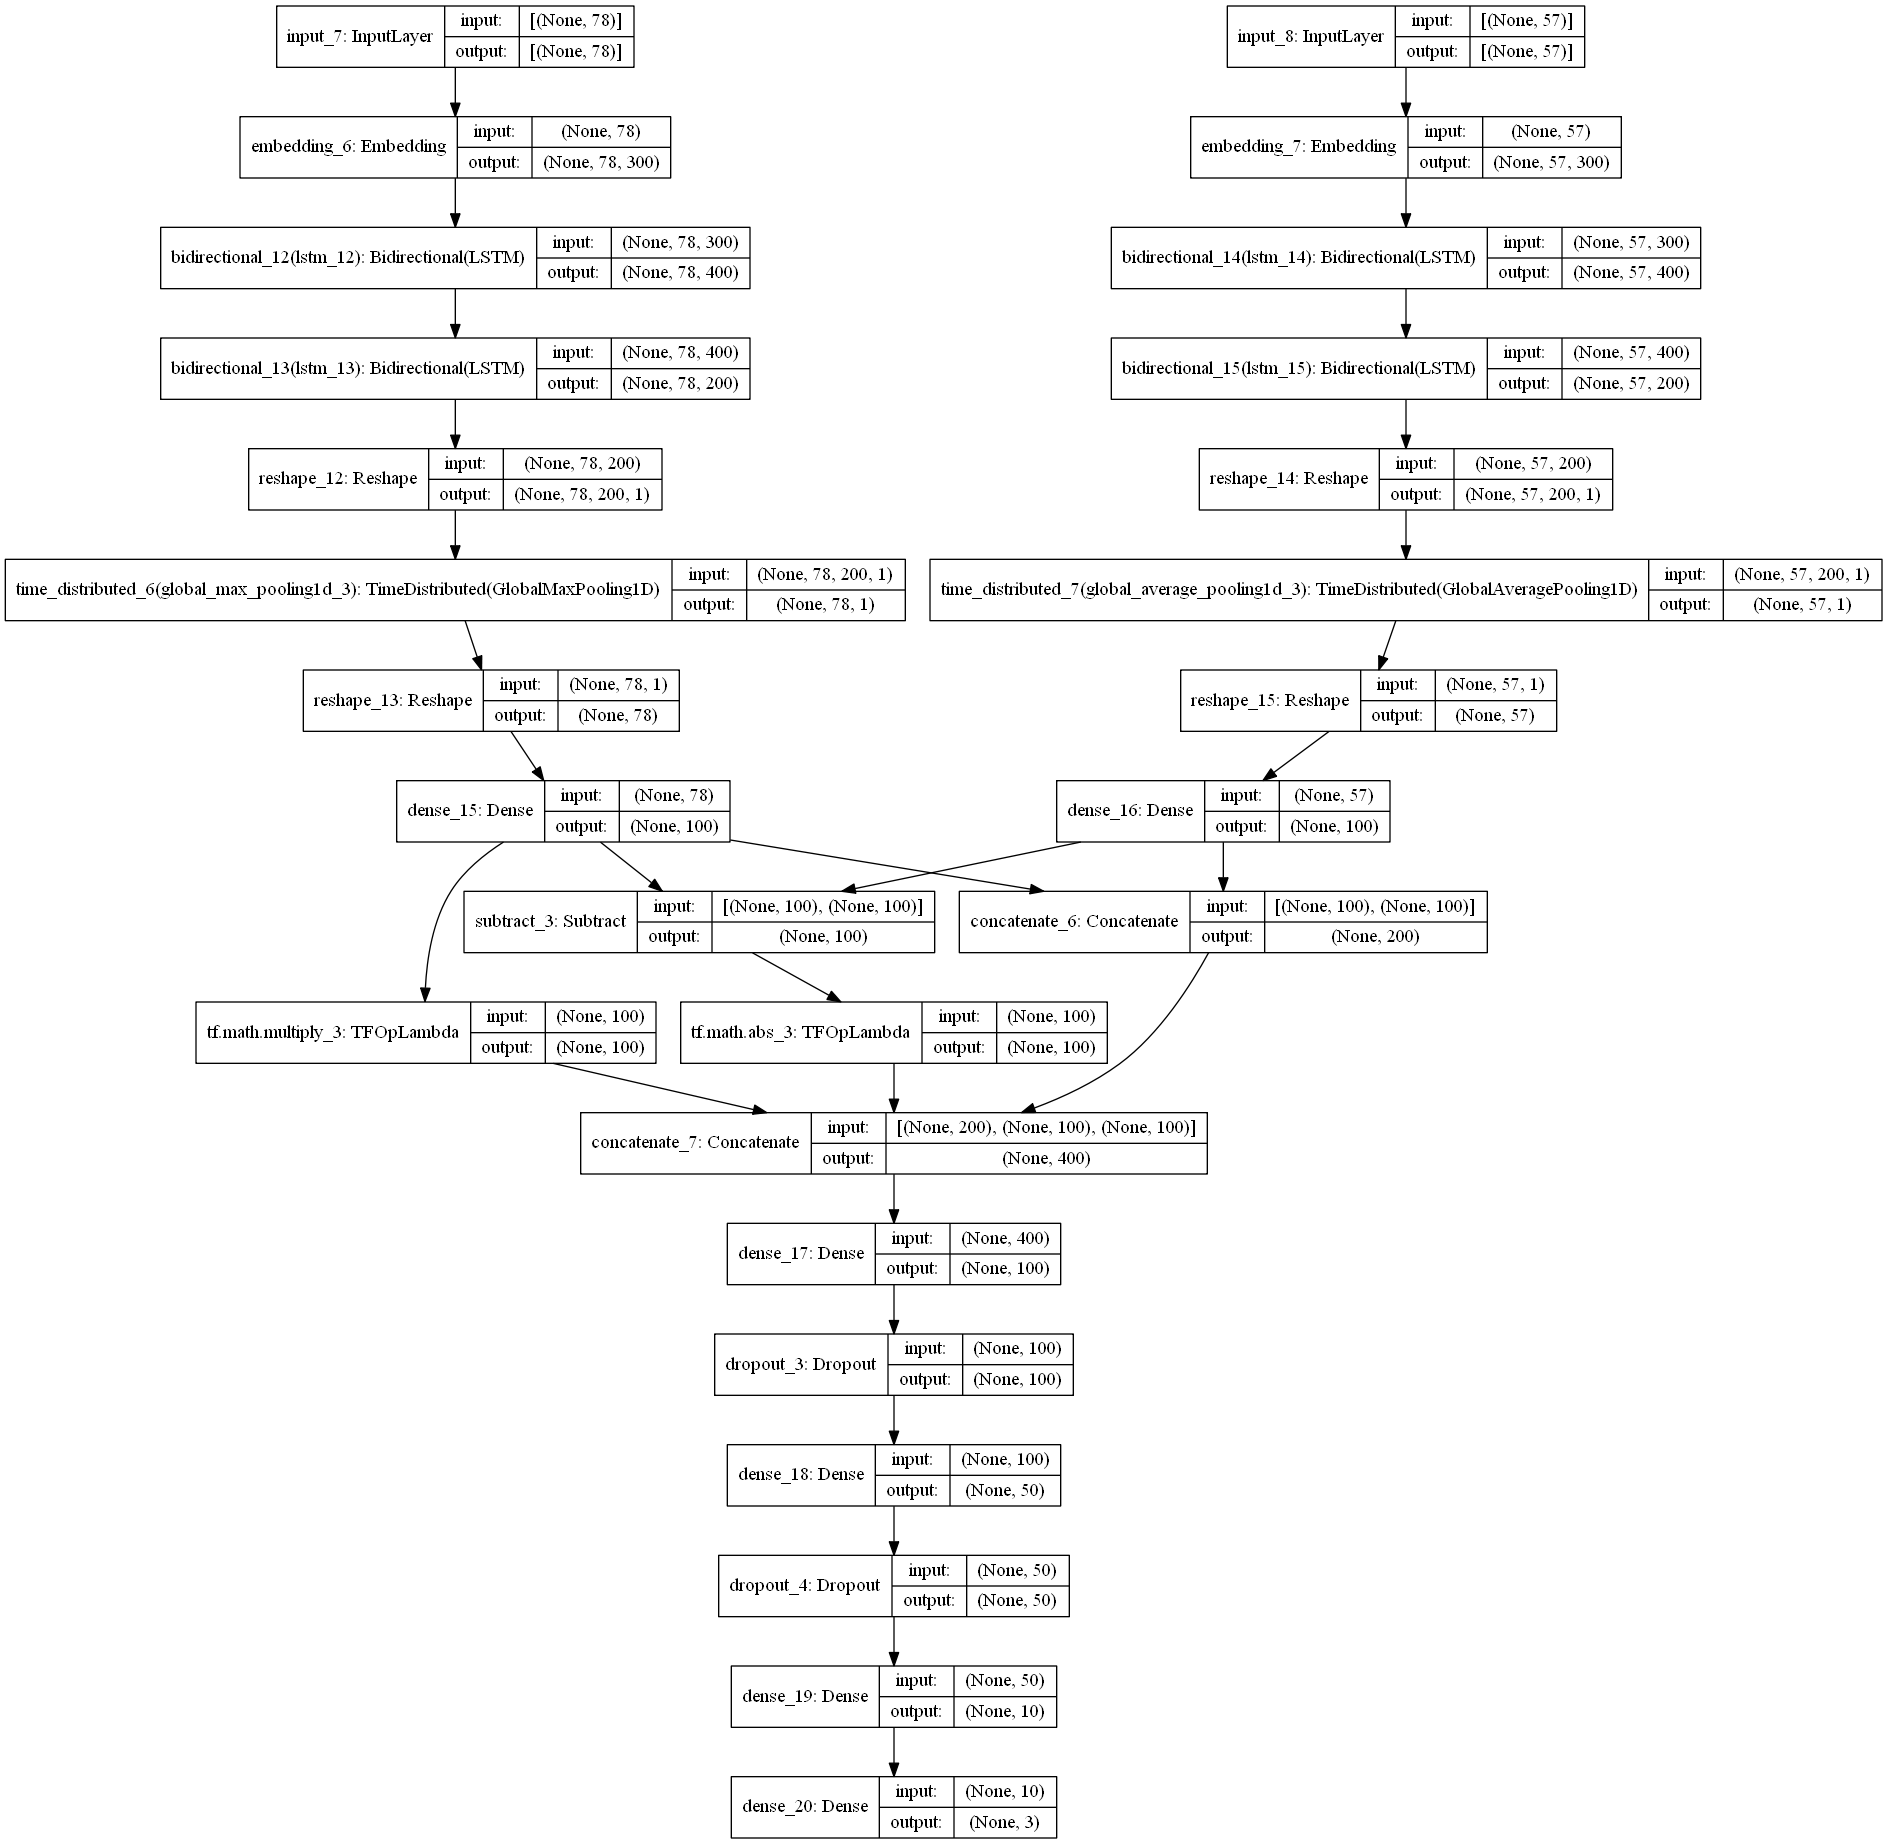

In [29]:
plot_model(model3, to_file='model3.png', show_shapes=True)

In [30]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import tensorflow as tf
# learning rate schedule
def step_decay(epoch):

    import math
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 6)
fname = 'best_model3.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [es, lrate, checkpoint]

In [31]:
model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
model3.fit([train_padded_1, train_padded_2], y_train_enc, epochs = 50, batch_size = 128, 
           validation_data = ([val_padded_1, val_padded_2], y_val_enc), callbacks = callbacks)

Epoch 1/50
4292/4292 [==============================] - 327s 73ms/step - loss: 0.8976 - accuracy: 0.5820 - val_loss: 0.8098 - val_accuracy: 0.6443
Epoch 2/50
4292/4292 [==============================] - 321s 75ms/step - loss: 0.8047 - accuracy: 0.6427 - val_loss: 0.7841 - val_accuracy: 0.6557
Epoch 3/50
4292/4292 [==============================] - 323s 75ms/step - loss: 0.7770 - accuracy: 0.6584 - val_loss: 0.7618 - val_accuracy: 0.6654
Epoch 4/50
4292/4292 [==============================] - 320s 74ms/step - loss: 0.7573 - accuracy: 0.6696 - val_loss: 0.7518 - val_accuracy: 0.6745
Epoch 5/50
4292/4292 [==============================] - 323s 75ms/step - loss: 0.7414 - accuracy: 0.6775 - val_loss: 0.7477 - val_accuracy: 0.6746
Epoch 6/50
4292/4292 [==============================] - 324s 75ms/step - loss: 0.7270 - accuracy: 0.6858 - val_loss: 0.7446 - val_accuracy: 0.6781
Epoch 7/50
4292/4292 [==============================] - 324s 75ms/step - loss: 0.7127 - accuracy: 0.6929 - val_loss: 0

# Bi-LSTM with attention with glove embeddings

In [32]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

**Following self attention has been applied:**

$$\begin{aligned}\overline{h_{i}} &= v_{i} \cdot \tanh(W \cdot h_{i} + b) + v_{b} \\ \alpha_{i} &= softmax(\overline{h_{i}}) \\ u &= \sum{\alpha_{i}h_{i}} \end{aligned}$$

**where, $h_{i}$ represent lstm hidden states, $W$ and $v$ represent affine transformations to calculate weights for each hidden states**

In [24]:
class Attention_Custom(tf.keras.layers.Layer):
    
    def __init__(self,att_units, inp_shape):
        super().__init__()
        self.att_units = att_units 
        self.inp_shape = inp_shape
        self.num_dim = self.inp_shape[-1] ##dimensions per time step
        self.ts = self.inp_shape[-2]  ##number of timesteps
        self.w = self.add_weight(shape = (self.num_dim,self.att_units), initializer='normal', trainable = True)
        self.b = self.add_weight(shape = (self.ts,self.att_units), initializer='zero', trainable = True)
        self.v = self.add_weight(shape = (self.att_units, self.num_dim), initializer = 'normal', trainable = True)
        self.v_b = self.add_weight(shape = (self.ts, self.num_dim))

    def call(self,x): 
        score = K.dot((K.tanh(K.dot(x,self.w)+self.b)),self.v)+self.v_b
        weights = K.softmax(score, axis=1)
        weighted_states = x*weights
        output = K.sum(weighted_states, axis=1)
        
        return weights, output
    

In [40]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_glove_1], trainable = False)(input1)
#lstm_s1 = Bidirectional(LSTM(256, return_sequences = True) , merge_mode = 'concat')(emb1)
lstm1 = Bidirectional(LSTM(128, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb1)
att_1 = Attention_Custom(64, lstm1.shape)
att_weights_1, context_1 = att_1.call(lstm1)
s1_dense = Dense(units = 300, activation = 'relu' )(context_1)


#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_glove_2], trainable = False)(input2)
#lstm_s2 = Bidirectional(LSTM(20, return_sequences = True))(emb2)
lstm2 = Bidirectional(LSTM(128, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb2)
att_2 = Attention_Custom(64, lstm2.shape)
att_weights_2, context_2 = att_2.call(lstm2)
s2_dense = Dense(units = 300, activation = 'relu' )(context_2)

#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
#point-wise product of sentence representations
prod = tf.math.multiply(s1_dense, s2_dense)
#point-wise absolute difference of sentence representations
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

#concatenating 
concatenated =  concatenate([merged_representations, prod, abs_diff])
# concatenated = tf.expand_dims(concatenated, axis=-1)
# conv1 = Conv1D(filters = 64, kernel_size = 3, strides=1, padding='valid')(concatenated)
# conv2 = Conv1D(filters = 32, kernel_size = 3, strides=1, padding='valid')(conv1)
# conv3 = Conv1D(filters = 16, kernel_size = 3, strides=1, padding='valid')(conv2)

# flat = Flatten()(conv3)
#MLP and threeway classifier
dense1 = Dense(units = 512, activation = 'relu')(concatenated)
#drop1 = Dropout(0.3)(dense1)
# dense2 = Dense(units = 50, activation = 'relu')(drop1)
output = Dense(units = 3, activation = 'softmax')(dense1)
model7 = Model(inputs = [input1, input2], outputs = output)




In [41]:
model7.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 78, 300)      5399100     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 57, 300)      9022800     input_14[0][0]                   
____________________________________________________________________________________________

In [42]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
# learning rate schedule
def step_decay(epoch):

    import math
    initial_lrate = 0.1
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#lrate = LearningRateScheduler(step_decay)
lrate = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, mode = 'auto')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 10)
fname = 'best_model7.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate,es]
#optimizer=tfa.optimizers.SGDW(weight_decay=0.99,momentum=0.9,learning_rate=0.1)
#optimizer=tfa.optimizers.AdamW(weight_decay=0.99,learning_rate=0.001)
optimizer=tf.optimizers.Adam(learning_rate=0.001)


#sgd = SGD(learning_rate = 0.1, )
model7.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
model7.fit([train_padded_1, train_padded_2], y_train_enc, epochs = 100, batch_size = 64, 
           validation_data = ([val_padded_1, val_padded_2], y_val_enc), callbacks = callbacks)

Epoch 1/100
8584/8584 [==============================] - 337s 39ms/step - loss: 0.7877 - accuracy: 0.6600 - val_loss: 0.6641 - val_accuracy: 0.7384
Epoch 2/100
8584/8584 [==============================] - 339s 39ms/step - loss: 0.6718 - accuracy: 0.7328 - val_loss: 0.6226 - val_accuracy: 0.7617
Epoch 3/100
8584/8584 [==============================] - 334s 39ms/step - loss: 0.6368 - accuracy: 0.7543 - val_loss: 0.5997 - val_accuracy: 0.7712
Epoch 4/100
8584/8584 [==============================] - 341s 40ms/step - loss: 0.6154 - accuracy: 0.7662 - val_loss: 0.5864 - val_accuracy: 0.7770
Epoch 5/100
8584/8584 [==============================] - 341s 40ms/step - loss: 0.5994 - accuracy: 0.7760 - val_loss: 0.5791 - val_accuracy: 0.7908
Epoch 6/100
8584/8584 [==============================] - 356s 41ms/step - loss: 0.5876 - accuracy: 0.7830 - val_loss: 0.5771 - val_accuracy: 0.7918
Epoch 7/100
8584/8584 [==============================] - 341s 40ms/step - loss: 0.5776 - accuracy: 0.7884 - val_

# Bi-LSTM with Attention on fasttext embeddings

In [34]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_fasttext_1], trainable = False)(input1)
#lstm_s1 = Bidirectional(LSTM(256, return_sequences = True) , merge_mode = 'concat')(emb1)
lstm1 = Bidirectional(LSTM(128, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb1)
att_1 = Attention_Custom(64, lstm1.shape)
att_weights_1, context_1 = att_1.call(lstm1)
s1_dense = Dense(units = 300, activation = 'relu' )(context_1)


#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_fasttext_2], trainable = False)(input2)
#lstm_s2 = Bidirectional(LSTM(20, return_sequences = True))(emb2)
lstm2 = Bidirectional(LSTM(128, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb2)
att_2 = Attention_Custom(64, lstm2.shape)
att_weights_2, context_2 = att_2.call(lstm2)
s2_dense = Dense(units = 300, activation = 'relu' )(context_2)

#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
#point-wise product of sentence representations
prod = tf.math.multiply(s1_dense, s2_dense)
#point-wise absolute difference of sentence representations
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

#concatenating 
concatenated =  concatenate([merged_representations, prod, abs_diff])
# concatenated = tf.expand_dims(concatenated, axis=-1)
# conv1 = Conv1D(filters = 64, kernel_size = 3, strides=1, padding='valid')(concatenated)
# conv2 = Conv1D(filters = 32, kernel_size = 3, strides=1, padding='valid')(conv1)
# conv3 = Conv1D(filters = 16, kernel_size = 3, strides=1, padding='valid')(conv2)

# flat = Flatten()(conv3)
#MLP and threeway classifier
dense1 = Dense(units = 512, activation = 'relu')(concatenated)
#drop1 = Dropout(0.3)(dense1)
# dense2 = Dense(units = 50, activation = 'relu')(drop1)
output = Dense(units = 3, activation = 'softmax')(dense1)
model8 = Model(inputs = [input1, input2], outputs = output)




In [35]:
model8.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 78, 300)      5399100     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 57, 300)      9022800     input_5[0][0]                    
____________________________________________________________________________________________

In [36]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
# learning rate schedule
def step_decay(epoch):

    import math
    initial_lrate = 0.1
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#lrate = LearningRateScheduler(step_decay)
lrate = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, mode = 'auto')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 10)
fname = 'best_model8.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate,es]
#optimizer=tfa.optimizers.SGDW(weight_decay=0.99,momentum=0.9,learning_rate=0.1)
#optimizer=tfa.optimizers.AdamW(weight_decay=0.99,learning_rate=0.001)
optimizer=tf.optimizers.Adam(learning_rate=0.001)


#sgd = SGD(learning_rate = 0.1, )
model8.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
model8.fit([train_padded_1, train_padded_2], y_train_enc, epochs = 100, batch_size = 64, 
           validation_data = ([val_padded_1, val_padded_2], y_val_enc), callbacks = callbacks)

Epoch 1/100
8584/8584 [==============================] - 335s 38ms/step - loss: 0.8649 - accuracy: 0.6084 - val_loss: 0.7642 - val_accuracy: 0.6739
Epoch 2/100
8584/8584 [==============================] - 337s 39ms/step - loss: 0.7751 - accuracy: 0.6686 - val_loss: 0.7407 - val_accuracy: 0.6846
Epoch 3/100
8584/8584 [==============================] - 337s 39ms/step - loss: 0.7234 - accuracy: 0.7017 - val_loss: 0.6674 - val_accuracy: 0.7303
Epoch 4/100
8584/8584 [==============================] - 338s 39ms/step - loss: 0.6876 - accuracy: 0.7219 - val_loss: 0.6438 - val_accuracy: 0.7430
Epoch 5/100
8584/8584 [==============================] - 341s 40ms/step - loss: 0.6680 - accuracy: 0.7338 - val_loss: 0.6266 - val_accuracy: 0.7544
Epoch 6/100
8584/8584 [==============================] - 337s 39ms/step - loss: 0.6515 - accuracy: 0.7426 - val_loss: 0.6153 - val_accuracy: 0.7569
Epoch 7/100
8584/8584 [==============================] - 336s 39ms/step - loss: 0.6399 - accuracy: 0.7492 - val_

# tuning Bi-lstm, attention with glove

In [37]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_glove_1], trainable = False)(input1)
#lstm_s1 = Bidirectional(LSTM(256, return_sequences = True) , merge_mode = 'concat')(emb1)
lstm1 = Bidirectional(LSTM(256, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb1)
att_1 = Attention_Custom(512, lstm1.shape)
att_weights_1, context_1 = att_1.call(lstm1)
s1_dense = Dense(units = 300, activation = 'relu' )(context_1)


#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_glove_2], trainable = False)(input2)
#lstm_s2 = Bidirectional(LSTM(20, return_sequences = True))(emb2)
lstm2 = Bidirectional(LSTM(256, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb2)
att_2 = Attention_Custom(512, lstm2.shape)
att_weights_2, context_2 = att_2.call(lstm2)
s2_dense = Dense(units = 300, activation = 'relu' )(context_2)

#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
#point-wise product of sentence representations
prod = tf.math.multiply(s1_dense, s2_dense)
#point-wise absolute difference of sentence representations
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

#concatenating 
concatenated =  concatenate([merged_representations, prod, abs_diff])
# concatenated = tf.expand_dims(concatenated, axis=-1)
# conv1 = Conv1D(filters = 64, kernel_size = 3, strides=1, padding='valid')(concatenated)
# conv2 = Conv1D(filters = 32, kernel_size = 3, strides=1, padding='valid')(conv1)
# conv3 = Conv1D(filters = 16, kernel_size = 3, strides=1, padding='valid')(conv2)

# flat = Flatten()(conv3)
#MLP and threeway classifier
dense1 = Dense(units = 512, activation = 'relu')(concatenated)
dense2 = Dense(units = 128, activation = 'relu')(dense1)
#drop1 = Dropout(0.3)(dense1)
# dense2 = Dense(units = 50, activation = 'relu')(drop1)
output = Dense(units = 3, activation = 'softmax')(dense2)
model9 = Model(inputs = [input1, input2], outputs = output)



In [39]:
model9.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 78, 300)      5399100     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 57, 300)      9022800     input_7[0][0]                    
____________________________________________________________________________________________

In [40]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
lrate = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, mode = 'auto')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 5)
fname = 'best_model9.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate,es]
#optimizer=tfa.optimizers.SGDW(weight_decay=0.99,momentum=0.9,learning_rate=0.1)
#optimizer=tfa.optimizers.AdamW(weight_decay=0.99,learning_rate=0.001)
optimizer=tf.optimizers.Adam(learning_rate=0.001)


#sgd = SGD(learning_rate = 0.1, )
model9.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
model9.fit([train_padded_1, train_padded_2], y_train_enc, epochs = 100, batch_size = 64, 
           validation_data = ([val_padded_1, val_padded_2], y_val_enc), callbacks = callbacks)

Epoch 1/100
8584/8584 [==============================] - 378s 43ms/step - loss: 0.7961 - accuracy: 0.6583 - val_loss: 0.6676 - val_accuracy: 0.7347
Epoch 2/100
8584/8584 [==============================] - 379s 44ms/step - loss: 0.6795 - accuracy: 0.7322 - val_loss: 0.6228 - val_accuracy: 0.7649
Epoch 3/100
8584/8584 [==============================] - 378s 44ms/step - loss: 0.6436 - accuracy: 0.7542 - val_loss: 0.6054 - val_accuracy: 0.7734
Epoch 4/100
8584/8584 [==============================] - 381s 44ms/step - loss: 0.6209 - accuracy: 0.7679 - val_loss: 0.5962 - val_accuracy: 0.7821
Epoch 5/100
8584/8584 [==============================] - 379s 44ms/step - loss: 0.6051 - accuracy: 0.7781 - val_loss: 0.5895 - val_accuracy: 0.7888
Epoch 6/100
8584/8584 [==============================] - 381s 44ms/step - loss: 0.5924 - accuracy: 0.7869 - val_loss: 0.5746 - val_accuracy: 0.7937
Epoch 7/100
8584/8584 [==============================] - 388s 45ms/step - loss: 0.5822 - accuracy: 0.7930 - val_

# Bi-LSTM with Attention on fasttext embeddings and extracted features

In [49]:
emb_dim = 300 

#getting sentence 1 representations
input1 = Input(shape=(maxlen1,)) #for sentence1 embeddings
emb1 = Embedding(input_dim = vocab_size_1, output_dim = emb_dim, input_length = maxlen1, 
                 weights = [embedding_matrix_glove_1], trainable = False)(input1)
#lstm_s1 = Bidirectional(LSTM(256, return_sequences = True) , merge_mode = 'concat')(emb1)
lstm1 = Bidirectional(LSTM(256, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb1)
att_1 = Attention_Custom(512, lstm1.shape)
att_weights_1, context_1 = att_1.call(lstm1)
print(context_1.shape)
s1_dense = Dense(units = 300, activation = 'relu' )(context_1)
print(s1_dense.shape)

#getting sentence2 representations
input2 = Input(shape=(maxlen2,)) #for sentence2 embeddings
emb2 = Embedding(input_dim = vocab_size_2, output_dim = emb_dim, input_length = maxlen2, 
                 weights = [embedding_matrix_glove_2], trainable = False)(input2)
#lstm_s2 = Bidirectional(LSTM(20, return_sequences = True))(emb2)
lstm2 = Bidirectional(LSTM(256, return_sequences = True, dropout=0.3, kernel_regularizer=l2(1e-5)), 
                      merge_mode = 'concat')(emb2)
att_2 = Attention_Custom(512, lstm2.shape)
att_weights_2, context_2 = att_2.call(lstm2)
s2_dense = Dense(units = 300, activation = 'relu' )(context_2)
print(s2_dense.shape)
#merging sentence1 and sentence2 representations
merged_representations = concatenate([s1_dense, s2_dense])
#point-wise product of sentence representations
prod = tf.math.multiply(s1_dense, s2_dense)
#point-wise absolute difference of sentence representations
subtracted = tf.keras.layers.Subtract()([s1_dense, s2_dense])
abs_diff = tf.math.abs(subtracted)

input3 = Input(shape=(29,)) #for extracted features
dense_1 = Dense(units = 16, activation = 'relu')(input3)

#concatenating 
concatenated =  concatenate([merged_representations, prod, abs_diff, dense_1])
# concatenated = tf.expand_dims(concatenated, axis=-1)
# conv1 = Conv1D(filters = 64, kernel_size = 3, strides=1, padding='valid')(concatenated)
# conv2 = Conv1D(filters = 32, kernel_size = 3, strides=1, padding='valid')(conv1)
# conv3 = Conv1D(filters = 16, kernel_size = 3, strides=1, padding='valid')(conv2)

# flat = Flatten()(conv3)
#MLP and threeway classifier
dense1 = Dense(units = 512, activation = 'relu')(concatenated)
dense2 = Dense(units = 128, activation = 'relu')(dense1)
#drop1 = Dropout(0.3)(dense1)
# dense2 = Dense(units = 50, activation = 'relu')(drop1)
output = Dense(units = 3, activation = 'softmax')(dense2)
model10 = Model(inputs = [input1, input2, input3], outputs = output)



(None, 512)
(None, 300)
(None, 300)


In [26]:
model10.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 78, 300)      5399100     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 57, 300)      9022800     input_3[0][0]                    
______________________________________________________________________________________________

In [27]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
lrate = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, mode = 'auto')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 5)
fname = 'best_model10.hdf5'
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True)
callbacks = [lrate,es]
#optimizer=tfa.optimizers.SGDW(weight_decay=0.99,momentum=0.9,learning_rate=0.1)
#optimizer=tfa.optimizers.AdamW(weight_decay=0.99,learning_rate=0.001)
optimizer=tf.optimizers.Adam(learning_rate=0.001)


#sgd = SGD(learning_rate = 0.1, )
model10.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
model10.fit([train_padded_1, train_padded_2, X_train_1], y_train_enc, epochs = 100, batch_size = 64, 
           validation_data = ([val_padded_1, val_padded_2, X_val_1], y_val_enc), callbacks = callbacks)

Epoch 1/100
8584/8584 [==============================] - 386s 44ms/step - loss: 0.8149 - accuracy: 0.6518 - val_loss: 0.6799 - val_accuracy: 0.7253
Epoch 2/100
8584/8584 [==============================] - 393s 46ms/step - loss: 0.7116 - accuracy: 0.7116 - val_loss: 0.6541 - val_accuracy: 0.7416
Epoch 3/100
8584/8584 [==============================] - 393s 46ms/step - loss: 0.6529 - accuracy: 0.7451 - val_loss: 0.6061 - val_accuracy: 0.7687
Epoch 4/100
8584/8584 [==============================] - 393s 46ms/step - loss: 0.6226 - accuracy: 0.7624 - val_loss: 0.5893 - val_accuracy: 0.7775
Epoch 5/100
8584/8584 [==============================] - 394s 46ms/step - loss: 0.6039 - accuracy: 0.7732 - val_loss: 0.5804 - val_accuracy: 0.7899
Epoch 6/100
8584/8584 [==============================] - 394s 46ms/step - loss: 0.5888 - accuracy: 0.7826 - val_loss: 0.5782 - val_accuracy: 0.7843
Epoch 7/100
8584/8584 [==============================] - 396s 46ms/step - loss: 0.5801 - accuracy: 0.7881 - val_

**the best performance by a model until now is val acc = 0.81, model: bi-lstm with self attention and glove embeddings**